In [1]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import signal, stats
import h5py
import glob
import pmefm
from collections import OrderedDict
from kpfm.util import h5filename
from kpfm.util import kpfm_data
from kpfm import lockin
from kpfm import util
reload(util)
reload(lockin)

import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

ks = 14950.0

@h5filename
def _h5toPMEFM(f):
    """On 2017-02-17, the modulation circuit had a gain of 0.2."""
    phi_t = f['CPD'][:]
    fs = f.attrs['Inputs.Scan rate [Hz]']
    dt = 1/fs
    T = phi_t.size * dt
    fx = f.attrs['Inputs.Pos Mod Freq (Hz)']
    # Gains
    # Amplififer: 15 V / V
    # Piezo:   0.125 µm / V
    # Rms to zero-to-peak: sqrt(2)
    # Summing circuit used 2017-02-17 had a gain of 0.2 on the modulation channel 
    x_m = f.attrs['Inputs.Pos Mod rms (V)'] * np.sqrt(2) * 0.2 * 15 * 0.125 
    x_tot = (f.attrs['Inputs.End scan [V]'] -
             f.attrs['Inputs.Start scan [V]']) * 0.125  # 0.125 µm/V
    v_tip = x_tot / T

    return {'fs': fs, 'fx': fx, 'v_tip': v_tip, 'x_m': x_m, 'phi_t': phi_t}

In [2]:
fname = "../data/KPFM-linescans/170217-1628DPh-BTBT-20V-50-nm-mod-x.h5"
fh = h5py.File(fname)
d = _h5toPMEFM(fh)

In [3]:
fir2 = lockin.lock2(1e3, 1.1, 4.4, d['fs']/d['v_tip'])
CPD = signal.fftconvolve(fh['CPD'][:], fir2, 'valid')

Response:
f   mag       dB
   0.000 1.000    0.000
   0.550 0.983   -0.151
   1.100 0.927   -0.656
   4.400 0.095  -20.488
   8.800 0.000 -101.830
 500.000 0.000 -270.187
1000.000 0.000 -270.321
11037.642 0.000 -345.562


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0855476269131
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6


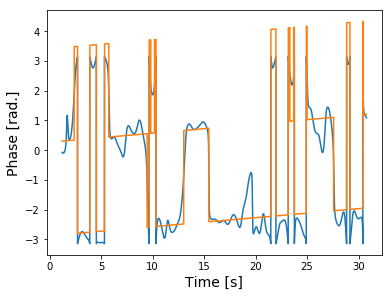

In [4]:
p50 = pmefm.PMEFMEx(**d)
p50.fir_filter(fir_ac=fir2, fir_dc=fir2)
p50.auto_phase()
p50.plot_phase()
p50.output()

In [5]:
m = kpfm_data("../data/KPFM/Feb 17 15-54  image 1.txt")
afm = np.loadtxt("../data/AFM/Feb 20 15-44  image 2.dat", skiprows=11)

In [6]:
afm_x = np.linspace(-67, 23, 128)
afm_y = np.linspace(-70, -20, 128)

In [7]:
height = (afm - afm.min()) * 25 * 15  - 100

In [8]:
slope = np.polyfit(np.arange(height.T[0].size), height.T[0], 1)[0]
corr = np.arange(128)*slope

In [9]:
height_corr = (height - corr.reshape(-1, 1))

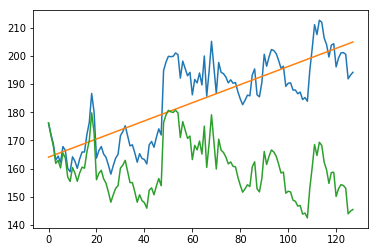

In [10]:
plt.plot(height.T[-1])
plt.plot(np.polyval(
    np.polyfit(np.arange(height.T[-1].size), height.T[-1], 1),
    np.arange(height.T[-1].size), )
        )
plt.plot(height_corr.T[-1])

In [11]:
height_corr = -(height_corr - np.percentile(height_corr, 1))

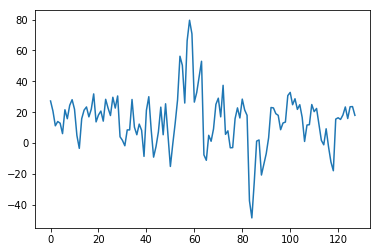

In [12]:
plt.plot(height[-1] - height[0])

In [13]:
ys = np.arange(11)
ys = np.array([0.2,0.2, 11.0, 11.0])
zs =np.array( [0, 1, 1, 0])
zs2 = np.zeros_like(ys)

In [14]:
height_corr_clip = np.clip(height_corr, -np.inf,0)

In [15]:
med_height = height_corr_clip

In [16]:
def normalize(x, n=2):
    return x / sum(abs(x)**n)**(1.0/n)

def arrow(x, y, z, xL, yL, ax, scale=0.1, scale_arrow=0.2, angle=30, **kwargs):
    L = a3.art3d.Line3D((x, x+xL), (y, y+yL), (z, z), color='k', **kwargs)
    pt_i = np.array([x, y])
    pt_f = np.array([x+xL, y+yL])
    delta = np.array([xL, yL]) *scale
    dnorm = normalize(delta)
    c = np.cos(np.radians(angle))
    s = np.sin(np.radians(angle))
    A1 = np.array([[c, -s], [s, c]])
    A2 = np.array([[c, s], [-s, c]])
    r1 = np.dot(A1, -dnorm)
    r2 = np.dot(A2, -dnorm)
    tri_coors = np.c_[dnorm,r1+dnorm,r2+dnorm].T *scale_arrow
    tri_coors = tri_coors - np.mean(tri_coors, axis=0) + pt_f

    M = np.zeros((3, 3))
    M[:, :-1] = tri_coors
    M[:, -1] = z
    
    tri = a3.art3d.Poly3DCollection([M], color='k', zorder=kwargs.get('zorder', 20)+5)
    ax.add_line(L)
    ax.add_collection(tri)
    return M

In [17]:
Ex = p50('E_dc')[10000::20000][:-1]
Ey = p50("E_mod")[10000::20000][:-1]
scan_dir = p50('x')[10000::20000][:-1]

In [18]:
# all_vec_data = [(scan_dir[i], Ex[i], Ey[i]) for i in [0, 1, 2, 4, 5, 6, 8, 9, 10]]

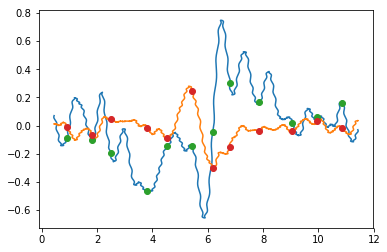

In [19]:
ii = np.array([ 10000,  30000,  45000, 75000, 90000, 110000, 126500, 140000,
       164000, 190000, 210000, 230000])

plt.plot(p50('x'), p50('E_dc'))
plt.plot(p50('x'), p50("E_mod"))
plt.plot(p50('x')[ii], p50('E_dc')[ii], 'o')
plt.plot(p50('x')[ii], p50("E_mod")[ii], 'o')

In [20]:
Ex = p50('E_dc')[ii]
Ey = p50("E_mod")[ii]
scan_dir = p50('x')[ii]

In [21]:
arr = np.array([
    [-0.1, -0.1]
])

In [22]:
x = m.vx * 0.125
y = m.vy * 0.125
mx, my = np.meshgrid(x -x.min(), y-y.min())
mx_afm, my_afm = np.meshgrid(afm_x - afm_x.min(), afm_y-afm_y.min())

height_corr_clip = np.clip(height_corr, -np.inf,0)

In [23]:
line_scan_dotted = np.array([ 0.15166231,  0.15169451,  0.15180077,  0.15198753,  0.15205193,
        0.15208413,  0.15208091,  0.15201007,  0.15184585,  0.15166875,
        0.15145944,  0.15139504,  0.15130488,  0.15134996,  0.15140148,
        0.151453  ,  0.15160757,  0.1515657 ,  0.15128878,  0.15097322,
        0.15087984,  0.15083476,  0.15089594,  0.15110202,  0.15124048,
        0.1515335 ,  0.15164621,  0.15175891,  0.15180077,  0.15186517,
        0.15198109,  0.15219039,  0.1524963 ,  0.15300184,  0.1532208 ,
        0.15360399,  0.15401938,  0.15446696,  0.15497573,  0.15533637,
        0.15581938,  0.15628306,  0.15659541,  0.15699469,  0.15725874,
        0.1575099 ,  0.15766768,  0.15782224,  0.15796071,  0.15796071,
        0.15796715,  0.15802833,  0.15805409,  0.15807985,  0.15819899,
        0.15829559,  0.15844049,  0.15861115,  0.15880436,  0.15902332,
        0.15955785,  0.16005373,  0.1607718 ,  0.16138039,  0.16192458,
        0.16223048,  0.16228522,  0.1619117 ,  0.16143835,  0.16080078,
        0.16012136,  0.15955463,  0.15915212,  0.15880436,  0.1586498 ,
        0.15840829,  0.15806375,  0.1577031 ,  0.15729416,  0.15685945,
        0.15648915,  0.15602546,  0.15574532,  0.15547161,  0.15526553,
        0.15503047,  0.15473422,  0.1544251 ,  0.15406768,  0.15375533,
        0.15330131,  0.15307268,  0.1528988 ,  0.15281508,  0.15277   ,
        0.15271848,  0.15265086,  0.15255748,  0.15249952,  0.15250596,
        0.15249952,  0.15245122,  0.15246732,  0.15245122,  0.15247698,
        0.15245444,  0.15244156,  0.15234495,  0.15230309,  0.15218717,
        0.15215175,  0.15207447,  0.15203905,  0.15200685,  0.15217429,
        0.15218395,  0.15221293,  0.15215175,  0.15208091,  0.15197787,
        0.15191347,  0.15182975,  0.15183297,  0.15186195,  0.15190381,
        0.15195533,  0.15199719,  0.15205193])

In [24]:
dz = np.array([0.0013, 0.0013, 0.0019, 0.0019])
line_scan_exaggerated = (line_scan_dotted - line_scan_dotted.min()) * 1 + line_scan_dotted.min()

In [25]:
Xtotal_afm = (mx_afm.max() - mx_afm.min())*0.125
Xtotal_kpfm = (my.max() - my.min())

In [26]:
x_offset = 0.4
offset = int(128*(x_offset)/11.25)

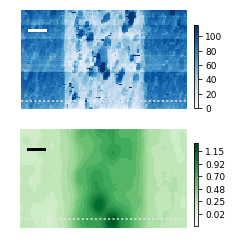

In [32]:
plt.rc('font', size=9)

green_levels = np.linspace(-0.2, 1.3, 21)


gray_colors = []
for color in mpl.cm.Greens(np.arange(21)/21):
    gray_colors.append(util.color2gray(color))

offset_colors = []
for color in gray_colors:
    if color > 0.5:
        offset_colors.append(color-0.3)
    else:
        offset_colors.append(color+0.3)

fig, axes = plt.subplots(nrows=2, figsize=(4*0.75, 4))

for ax in axes:
    ax.set_axis_off()
    

Xtotal_plot = (Xtotal_afm - 2*x_offset)



contour_set = axes[0].imshow(med_height[:, offset*2:] - med_height[:, offset*2:].min(), 
                             cmap=mpl.cm.Blues, origin="lower",
            # extent = (left, right, bottom, top)
               extent=[0, 
                       Xtotal_afm - 2*x_offset, 
                       0, (my_afm.max() - my_afm.min())*0.125]
              )

ylinescan = my_afm[11, 0]*0.125

axes[0].axhline(5,0.05, 0.05 + 1/Xtotal_plot, color='1', linewidth=3)
axes[0].axhline(ylinescan, color='0.9', linestyle=':')

kpfm_contours = axes[1].contourf(my[:-offset*2, :], mx[:-2*offset, :], m.ch1.T[:-2*offset, :], 
                                 green_levels, cmap=mpl.cm.Greens)
# ax.contour(my[:-offset*2, :], mx[:-2*offset, :], m.ch1.T[:-2*offset, :], 
#                                  green_levels,
#            cmap=mpl.cm.Greens, alpha=1, linewidth=0.1)

axes[1].axhline(5,0.05, 0.05 + 1/Xtotal_plot, color='0', linewidth=3)
axes[1].axhline(ylinescan, color='0.9', linestyle=':')

cbar_axis_top = fig.add_axes([0.93, 0.54, 0.02, 0.29])
cbar_top = fig.colorbar(contour_set, cax=cbar_axis_top, orientation='vertical', )
cbar_top.ax.set_yticklabels(['0', "20", "40", "60", "80", "100"])
cbar_top.solids.set_edgecolor("face")


cbar_axis = fig.add_axes([0.93, 0.13, 0.02, 0.29])
cbar = fig.colorbar(kpfm_contours, cax=cbar_axis, orientation='vertical', format="%.2f", )
cbar.set_ticks([0.025, 0.25, 0.475, 0.7, 0.925, 1.15])
cbar.ax.set_yticklabels(["0.02", "0.25", "0.48", "0.70", "0.92", "1.15"])
cbar.solids.set_edgecolor("face")

In [33]:
fig.savefig("../figs/03ab-afm-kpfm-2d.pdf", bbox_inches='tight', pad_inches=0.2)